In [1]:
using LinearAlgebra
using Plots
using Random
using Distributions
using Polynomials
using BenchmarkTools
using LaTeXStrings
using ProgressMeter

In [2]:
include("../helperFunctions.jl")

PCA (generic function with 1 method)

In [3]:
function ALPCAH_PALM(Y, d::Int; γ::Real=0.1, ϵ::Real=1e-9, niter::Int=100, varfloor::Real=1e-9)
    D,N = size(Y)

    γ_L = 1 + γ
    γ_R = 1 + γ
    γ_pie = 1 + γ
    
    T = svd(Y)
    L = T.U[:,1:d]*Diagonal(sqrt.(T.S[1:d]))
    R = T.V[:,1:d]*Diagonal(sqrt.(T.S[1:d]))
    Π = grouplessVarianceUpdate(Y, L*R'; varfloor=varfloor) # variances
    
    for k = 1:niter
        L_L = norm(R,2)^2 * opnorm(Diagonal(Π.^-1), 2) + ϵ
        I_L = L + 1/(γ_L*L_L)*(Y-L*R')*Diagonal(Π.^-1)*R
        L = (γ_L*L_L)/(ϵ + γ_L*L_L)*I_L

        L_R = norm(L, 2)^2 + ϵ
        I_R = R + 1/(γ_R*L_R)*Diagonal(Π.^-1)*(Y-L*R')'*L
        R = (γ_R*L_R)/(ϵ + γ_R*L_R) * I_R

        L_pie = 1/(varfloor^3) * norm(norm.(eachcol(Y-L*R'), 2), Inf) + D/(2*varfloor^2)
        I_pie = Diagonal(Π) + 1/(2*γ_pie*L_pie)*( ((Y-L*R')'*(Y-L*R')) .* Diagonal(Π.^-2) )
        for i = 1:N
            Π[i] = maximum(roots(Polynomial([D/2, -1*γ_pie*L_pie*I_pie[i,i], γ_pie*L_pie])))
        end
        Π = max.(Π, varfloor)

    end
    
    U = svd(L).U
    return U, L, R, Π
end

function LR_ALPCAH(Y::Matrix,d::Int; varfloor::Real=1e-9, alpcahIter::Int = 1000, fastCompute::Bool=false)
    rank = d
    D,N = size(Y)

    T = svd(Y)
    L = T.U[:,1:rank]*Diagonal(sqrt.(T.S[1:rank]))
    R = T.V[:,1:rank]*Diagonal(sqrt.(T.S[1:rank]))

    # variance method initialization
    Π = grouplessVarianceUpdate(Y, L*R'; varfloor=varfloor)
    #Π = Diagonal(v)

    for i=1:alpcahIter
        # left right updates
        L = Y*Diagonal(Π.^-1)*R*inv(R'*Diagonal(Π.^-1)*R)
        R = Y'*L*inv(L'*L)
        # variance updates
        Π = grouplessVarianceUpdate(Y, L*R'; varfloor=varfloor)
        #Π = Diagonal(v.^-1)
    end
    # extract left vectors from L
    U = svd(L).U
    return U, L, R, Π
end

function grouplessVarianceUpdate(Y::Matrix, X::Matrix; varfloor::Real=1e-9)
    D= size(Y)[1]
    Π = (1/D)*norm.(eachcol(Y - X)).^2
    return max.(Π, varfloor)
end

grouplessVarianceUpdate (generic function with 1 method)

In [4]:
function costFunction(Y,L,R,Π; ϵ::Real=0.0)
    return 0.5*norm((Y-L*R')*Diagonal(Π.^-0.5),2)^2 + 0.5*size(Y)[1]*log10(det(Diagonal(Π))) + 0.5*ϵ*norm(L,2)^2 + 0.5*ϵ*norm(R,2)^2
end

costFunction (generic function with 1 method)

In [5]:
U = generateSubspace(100, 3)
Y = generateData(U, [0.01; 20], [10; 200]);

In [6]:
U_PCA = PCA(Y, 3)
errorPCA = affinityError(U, U_PCA)

0.8456130810693316

In [7]:
T = svd(Y)
L = T.U[:,1:3]*Diagonal(sqrt.(T.S[1:3]))
R = T.V[:,1:3]*Diagonal(sqrt.(T.S[1:3]))
Π = grouplessVarianceUpdate(Y, L*R'; varfloor=1e-9)
costFunction(Y,L,R,Π; ϵ=1e-9)

22988.369258859257

In [8]:
U_ALPCAH,L,R,Π = LR_ALPCAH(Y,3; alpcahIter = 100)
affinityError(U, U_ALPCAH)

0.1319328401635845

In [9]:
costFunction(Y,L,R,Π; ϵ=1e-9)

21186.16119313764

In [10]:
U_PALM,L,R,Π = ALPCAH_PALM(Y, 3; γ=1e-9, ϵ=1e-9, niter=100)
affinityError(U, U_PALM)

0.6252333919685868

In [11]:
costFunction(Y,L,R,Π; ϵ=1e-9)

23277.727570887597

In [61]:
iterVec = [0 1 2 25 50 75 100 200 300 400 500]
numTrials = 50
subspaceDim = 3
ambientDim = 100

palmError = zeros(numTrials,length(iterVec))
alpcahError = zeros(numTrials,length(iterVec))
palmCost = zeros(numTrials,length(iterVec))
alpcahCost = zeros(numTrials,length(iterVec))
pcaCost = zeros(numTrials)
errorPCA = zeros(numTrials)

@showprogress for i = 1:numTrials
    # generate data
    U = generateSubspace(ambientDim, subspaceDim)
    Y = generateData(U, [0.01; 20], [10; 200]);
    # pca
    U_PCA = PCA(Y, subspaceDim)
    errorPCA[i] = affinityError(U, U_PCA)
    T = svd(Y)
    L = T.U[:,1:subspaceDim]*Diagonal(sqrt.(T.S[1:subspaceDim]))
    R = T.V[:,1:subspaceDim]*Diagonal(sqrt.(T.S[1:subspaceDim]))
    Π = grouplessVarianceUpdate(Y, L*R'; varfloor=1e-9)
    pcaCost[i] = costFunction(Y,L,R,Π)
    # other methods
    for k = 1:length(iterVec)
        # ALPCAH ALT MIN
        U_ALPCAH, L, R, Π = LR_ALPCAH(Y,subspaceDim; alpcahIter = iterVec[k])
        alpcahError[i,k] = affinityError(U, U_ALPCAH)
        alpcahCost[i,k] =costFunction(Y,L,R,Π; ϵ=1e-9)
        # ALPCAH PALM
        U_PALM, L, R, Π = ALPCAH_PALM(Y, subspaceDim; γ=1e-9, ϵ=1e-9, niter= iterVec[k])
        palmError[i,k] = affinityError(U, U_PALM)
        palmCost[i,k] = costFunction(Y,L,R,Π; ϵ=1e-9)
    end

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


In [62]:
palmError_mean = mean(palmError, dims=1)
alpcahError_mean = mean(alpcahError, dims=1)
palmCost_mean = mean(palmCost, dims=1)
alpcahCost_mean = mean(alpcahCost, dims=1)
pcaCost_mean = mean(pcaCost)
errorPCA_mean = mean(errorPCA);

palmError_std = std(palmError, dims=1)
alpcahError_std = std(alpcahError, dims=1)
palmCost_std = std(palmCost, dims=1)
alpcahCost_std = std(alpcahCost, dims=1)
pcaCost_std = std(pcaCost)
errorPCA_std = std(errorPCA);

In [63]:
color = palette(:default)

In [64]:
# plot(xlabel="Iterations", ylabel=L" \Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F ", legendfontpointsize=12,xtickfontsize=12,ytickfontsize=12,guidefontsize=16,titlefontsize=18, legend=false)
# hline!([errorPCA_mean], ribbon=errorPCA_std, linewidth=3, color=color[3], label="PCA", fillalpha=0.3)
# plot!(vec(iterVec),vec(alpcahError_mean), ribbon=alpcahError_std, label="LR-ALPCAH (AltMin)", linewidth=3, markershape=:o, color=color[end-2], fillalpha=0.3)
# plot!(vec(iterVec), vec(palmError_mean), ribbon=palmError_std, label="LR-ALPCAH (PALM)", linewidth=3, markershape=:x, color=color[1], fillalpha=0.3)
# plot!(ylim=(0.0,0.9))
# annotate!(480, 0.75, "PCA", color[3])
# annotate!(200, 0.5, "LR-ALPCAH (PALM)", color[1])
# annotate!(175, 0.05, "LR-ALPCAH (AltMin)", color[end-2])
# #savefig("palm_result2.svg")

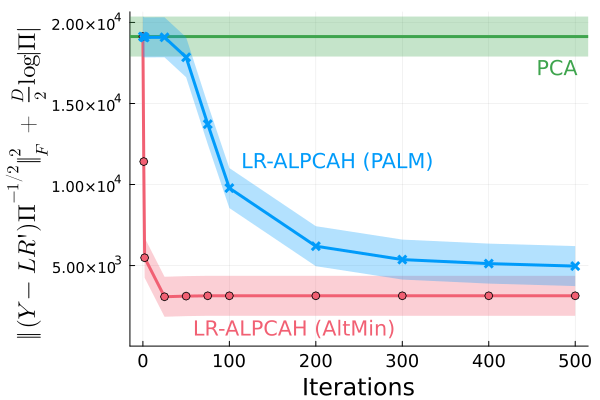

In [67]:
using Plots.Measures
plot(xlabel="Iterations", ylabel=L" \Vert (Y - LR') \Pi^{-1/2} \Vert_F^2 + \dfrac{D}{2} \log|\Pi|", legendfontpointsize=12,xtickfontsize=12,ytickfontsize=10,guidefontsize=16,titlefontsize=18, legend=false)
hline!([pcaCost_mean*errorPCA_mean], ribbon=pcaCost_mean*errorPCA_std, linewidth=3, color=color[3], label="PCA", fillalpha=0.3)
plot!(vec(iterVec),vec(pcaCost_mean*alpcahError_mean), ribbon=pcaCost_mean*alpcahError_std, label="LR-ALPCAH (AltMin)", linewidth=3, markershape=:o, color=color[end-2], fillalpha=0.3)
plot!(vec(iterVec), vec(pcaCost_mean*palmError_mean), ribbon=pcaCost_mean*palmError_std, label="LR-ALPCAH (PALM)", linewidth=3, markershape=:x, color=color[1], fillalpha=0.3)
plot!(ylim=(pcaCost_mean*minimum(alpcahError_mean)*0.01, pcaCost_mean*0.9 ), left_margin=3mm)
annotate!(480, pcaCost_mean*0.75, "PCA", color[3])
annotate!(225, pcaCost_mean*0.5, "LR-ALPCAH (PALM)", color[1])
annotate!(175, pcaCost_mean*0.05, "LR-ALPCAH (AltMin)", color[end-2])
#savefig("palm_result.svg")

In [44]:
# using Plots.PlotMeasures
# plot(xlabel="Iterations", ylabel=L" \Vert (Y - LR') \Pi^{-\frac{1}{2}} \Vert_F^2 + \dfrac{D}{2} \log|\Pi|", 
#     legendfontpointsize=12,xtickfontsize=12,ytickfontsize=12,guidefontsize=16,titlefontsize=18, legend=:right,left_margin=4mm)
# plot!(ylim=(21000,28000))
# hline!([pcaCost_mean], ribbon=pcaCost_std,linewidth=4, color=:black, label="PCA")
# #plot!(vcat(0,vec(iterVec)),vcat(pcaCost_mean,vec(alpcahCost_mean)), ribbon=hcat(pcaCost_std, alpcahCost_std), label="LR-ALPCAH", linewidth=2, markershape=:o, color=color[1])
# plot!(vec(iterVec),vec(alpcahCost_mean), ribbon=hcat(pcaCost_std, alpcahCost_std), label="LR-ALPCAH", linewidth=2, markershape=:o, color=color[1])
# plot!(vec(iterVec), vec(palmCost_mean), label="PALM LR-ALPCAH", linewidth=2, markershape=:x, color=color[2])

In [45]:
# plot(xlabel="Time (ms)", ylabel=L" \Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F ", legendfontpointsize=12,xtickfontsize=12,ytickfontsize=12,guidefontsize=16,titlefontsize=18, legend=:right)
# plot!(xlim=(-0.01,300))
# hline!([errorPCA], linewidth=4, color=:black, label="PCA")
# plot!(vcat(0,vec(alpcahTime./1e6)),vcat( errorPCA,alpcahError), label="LR-ALPCAH", linewidth=2, markershape=:o, color=color[1])
# plot!(palmTime./1e6, palmError, label="PALM LR-ALPCAH", linewidth=2, markershape=:x, color=color[2])